In [33]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
import ast

from langchain import PromptTemplate
from langchain.chains import SequentialChain
from langchain.chains import LLMChain
from langgraph.graph import START, END , StateGraph
import random
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
import os
import json
model = 'qwen-qwq-32b'
model1 = 'llama-3.3-70b-versatile'

In [34]:
class State(TypedDict):
    plot : str
    max_chapters : int
    story_name : str
    chapters : dict
    current_chapter : int
    current_story : str
    flow_messages : str
    max_chapters : int
    chapter_score : int

In [64]:
chapter_template = """
{default}

(DONT CONSIDER DURING FIRST TIME)
Your part of Agentic AI , So slove the error if it is metioned , just now generated chapter.
Error Caused :- {error_caused} 
Error :- {error}


Template for Story Creation with Agentic AI

Objective:
You are a vital component of Agentic AI, designed to assist users in creating engaging stories.

Remeber : 
The plot of story and chapter should be UNIQUE and more more natural.

Your Role:
- Develop chapter titles based on the user's input.
- Generate story content upon user requests, aligning with the specified chapters.

Your Mission:
Upon receiving this prompt, consider it the beginning of a new story. Your primary task is to create compelling story chapters based on the user input provided below:


Now, it's time to generate chapter titles for the story. Ensure they align with the specified plot of the story 
{plot} 
and adhere to the maximum number of chapters ({max_chapters}).

Your return type (json) :
{chapter_response_formate}

STRRICT RULE : NO EXTRA WORDS RATHER THAN CHAPTERS
"""

chapter_response_formate = '''
    {
        "Story_Name" : " ",
        "Chapters" : {
            "chapter_number" : chapter name,
            .....
        }
    }
'''


story_template = '''
{default}

(DONT CONSIDER DURING FIRST TIME)
Your part of Agentic AI , So slove the error if it is metioned , just now generated chapter.
Error Caused :- {error_caused} 
Error :- {error}

(DONT CONSIDER DURING FIRST TIME)
Your part of Agentic AI ,Rating given ignore it during first time (during score = 0 ) if score is not 0 ,then consider it as the changes needed,
just now generated chapter.
Score Given :- {score} 
Suggested Changes :- {changes}

Please generate a **very long, meaningful story**.

We are starting the story chapter-wise.

⚠️ IMPORTANT:
- The story must be extremely detailed and meaningful.
- Each response should only contain **one chapter**.
- The response must be returned in **strict JSON format** as shown below.
- The "Chapter_Story" should be in a **single line**. Use **'\\n'** (escaped newline) to separate paragraphs. Do NOT use actual line breaks.
- The response when used with `json.loads()` should **raise a JSONDecodeError** if anything is malformed (very very important).

Chapter Number: {chapter_number}
Chapter Name: {chapter_name}

🔁 RESPONSE FORMAT (strictly follow this):
{story_response_format}

Make sure:
- The JSON is valid. I will be using `json.loads()` to parse it.
- Escape all special characters properly inside the JSON.

BEGIN.
'''
  
story_response_format = '''
{
    "Chapter_Name": "Chapter title here",
    "Chapter_Story": "This is a long story...\\nSecond paragraph starts here...\\nThird paragraph continues the story..."
}
'''


score_template = """
(DONT CONSIDER DURING FIRST TIME)
Your part of Agentic AI , So slove the error if it is metioned , just now generated chapter.
Error Caused :- {error_caused} 
Error :- {error}

You are a part of Agentic AI. Your role is to **evaluate the story with utmost sincerity and objectivity**, and assign a score out of 100.

🔴 IMPORTANT: YOU MUST FOLLOW THESE RULES STRICTLY 🔴
1. Your scoring should be **highly sincere, fair, and thoughtful**.
2. You MUST return the score and recommended changes **strictly** in the specified JSON format.
3. Make sure the JSON is **valid and parsable** using `json.loads()`.
4. If score is more than or equal to 95, no need of changes, just pass empty list.


---

📝 Here is the story information you need to evaluate:

Story Name: {story_name}

Chapter Name: {chapter_name}

Chapter Story:
{chapter_story}

---

📤 REQUIRED RESPONSE FORMAT (strictly follow this):

{score_response_format}

⚠️ Guidelines:
- The JSON **must be valid**.
- Escape any special characters as needed to ensure parsing.
- Keep the recommendations list short (1 or 2 points max).
"""


score_response_format = '''
{
    "Score" : (Between 1 to 100),
    "Changes" : python list recommanded (only 1 or 2 )
}

'''

elaborate_template = '''
You are a part of Agentic AI. Your role is to **elaborate the story with meaningfull manner**.

---

📝 Here is the story information you need to elaborate:

Story Name: {story_name}

Chapter Name: {chapter_name}

Chapter Story:
{chapter_story}

---

📤 REQUIRED RESPONSE FORMAT (strictly follow this):

{elaborate_response_format}

⚠️ Guidelines:
- The JSON **must be valid**.
- Escape any special characters as needed to ensure parsing.

'''

elaborate_response_format = '''
{
    'elaborated_story' :
}
'''


grammar_template = '''

(DONT CONSIDER DURING FIRST TIME)
Your part of Agentic AI , So slove the error if it is metioned , just now generated chapter.
Error Caused :- {error_caused} 
Error :- {error}

{default}
You are part of an Agentic AI system. Your task is to **correct the grammar of the story in a meaningful way**, preserving its original structure and intent.

An elaborator agent has already expanded the story; you should only fix grammatical errors without altering the plot, length, or overall flow.

Story Name: {story_name}
Chapter Name: {chapter_name}

Chapter Text:
{chapter_story}

Points to follow (strictly):
1. Do not change the story's size, structure, or plot.
2. Only correct grammatical mistakes—retain all original meanings and nuances.
3. Your output must match the required format exactly.

📤 REQUIRED RESPONSE FORMAT (strictly follow):

{grammar_response_format}


'''

grammar_response_format = '''
<grammar_corrected>
Corrected story text goes here...
</grammar_corrected>
'''


In [65]:
chapter_prompt = PromptTemplate(
    input_variables = ['plot' , 'max_chapters', 'chapter_response_formate','error_caused','error'],
    template = chapter_template
)

story_prompt = PromptTemplate(
    input_variables = ['chapter_number','chapter_name','story_response_format','error_caused','error','score','changes'],
    template = story_template
)

score_prompt = PromptTemplate(
    input_variables = ['story_name','chapter_name','chapter_story','score_response_format'],
    template = score_template
)

elaborate_prompt = PromptTemplate(
    input_varaibles = ['story_name','chapter_name','chapter_story','elaborate_response_format','elaborate_response_format'],
    template = elaborate_template
)

grammar_prompt = PromptTemplate(
    input_varaibles = ['default','story_name','chapter_name','chapter_story','grammar_response_format','error_caused','error'],
    template = grammar_template
)


In [66]:
llm = ChatGroq(model=model)
llm2 = ChatGroq(model=model1)

story_memory = ConversationBufferMemory(   
    input_key = 'default',
    memory_key="chat_history",   
    return_messages=False
)

grammar_chain = ConversationBufferMemory(
    input_key = 'default',
    memory_key= 'chat_history',
    return_messages= False
)

chapter_chain = LLMChain(
    llm = llm,
    prompt = chapter_prompt,
    memory = story_memory
)

story_chain = LLMChain(
    llm=llm,
    prompt = story_prompt,
    memory = story_memory
)

score_chain = LLMChain(
    llm = llm2,
    prompt = score_prompt
)

elaborate_chain = LLMChain(
    llm = llm,
    prompt = elaborate_prompt
)

grammar_chain = LLMChain(
    llm = llm,
    prompt = grammar_prompt
)



In [38]:
def Chapter_Maker(state : State) -> State :
    print("Chapter Maker Started")
    plot = state['plot']
    max_chapters = state['max_chapters']
    default = "Now"
    tries = 0
    error = "First time"
    error_caused = False




    while tries < 6 :
        try :
            response = chapter_chain.invoke({
                'default' : default,
                'plot' : plot,
                'max_chapters' : max_chapters,
                'chapter_response_formate' : chapter_response_formate,
                'error': error,
                'error_caused' : error_caused
            })

            response = response['text']
            start = response.find('{')
            end = response.rfind('}')
            formatted_response = json.loads(response[start:end+1])
            break

        except Exception as e:
            tries +=1
            error  =  e 
            error_caused = True

            print(f"{tries}❌ Caught error: {e!r} ,  retrying...")
    
    print(formatted_response)

    with open('input.txt','a') as fp :
        fp.write(formatted_response['Story_Name'] + "\n\n\n" )
        for chp_name in formatted_response['Chapters'] :
            fp.write(chp_name +'\t\t:-  '+ formatted_response['Chapters'][chp_name] + "\n\n" )

    state['story_name'] = formatted_response['Story_Name']
    state['chapters'] = formatted_response['Chapters']
    state['current_chapter'] = 0
    state['max_chapters'] = len(state['chapters'])
    
    print("Chapter Maker Ended")
    return state

In [39]:
def end_or_not(state):

    value = state['current_chapter']
    
    max_chapters = state['max_chapters']

    return "NOT_DONE" if value < max_chapters else "DONE"

In [40]:
def Story_Maker(state : State) -> State:
    print("Story Maker Started")
    value = state['current_chapter']
    all_chapters = list(state['chapters'].keys())
    if len(all_chapters) == value :
        return state
    chapter_name = state['chapters'][all_chapters[value]]
    error = "First time"
    error_caused = False
    tries = 0


    score = state.get('chapter_score',0)

    if score :
        score = int(score)
    else :
        score = 0
    

    with open('chapter_changes.txt','r') as fp:
        changes = fp.read()

    if  not changes :
        changes = "First Time"


    while tries < 6 :
        try :
            story_response = story_chain({
                'default' : "Now",
                'chapter_number' : all_chapters[value],
                'chapter_name' : chapter_name,
                'story_response_format' : story_response_format,
                'error_caused' : error_caused,
                'error' : error,
                'score' : score,
                'changes' : changes
            })

            response = story_response['text']
            start = response.find('{')
            end = response.rfind('}')
            formatted_response = json.loads(response[start:end+1])
            state['current_story'] = formatted_response['Chapter_Story']
            break

        except Exception as e:
            tries +=1
            error  =  e 
            error_caused = True

            print(f"{tries}❌ Caught error: {e!r} ,  retrying...")

    # state['current_chapter'] += 1
    # with open('story_pointer.txt','w') as fp :
    #     fp.write(str(state['current_chapter']))
    
    # if not os.path.exists(state['story_name']) :
    #     os.makedirs(state['story_name'])

    # file_name = os.path.join(state['story_name'],chapter_name)

    # with open(file_name ,'w') as fp :
    #     fp.write(formatted_response['Chapter_Name'] + "\n\n\n")
    #     fp.write(formatted_response['Chapter_Story'])

    print("Story Maker Ended")
    return state


In [41]:
def score_story(state : State) -> State:
    
    print("Score Story Started")
    value = state['current_chapter']
    all_chapters = list(state['chapters'].keys())
    chapter_name = state['chapters'][all_chapters[value]]

    story_name = state['story_name']

    chapter_story = state['current_story']

    error = "First time"
    error_caused = False
    tries = 0
    while tries < 6 :
        try :
            score_response = score_chain({
                'story_name' : story_name,
                'chapter_name' : chapter_name,
                'chapter_story' : chapter_story,
                'score_response_format' : score_response_format,
                'error_caused' : error_caused,
                'error' : error
            })

            response = score_response['text']
            start = response.find('{')
            end = response.rfind('}')
            formatted_response = json.loads(response[start:end+1])
            break

        except Exception as e:
            tries +=1
            error  =  e 
            error_caused = True

            print(f"{tries}❌ Caught error: {e!r} ,  retrying...")

    score = formatted_response['Score']
    changes = formatted_response['Changes']

    if score >= 95 :

        print(f'Chapter {value} passeed with score {score}')
        state['chapter_score'] = score

        # state['current_chapter'] += 1
        
        # with open('story_pointer.txt','w') as fp :
        #     fp.write(str(state['current_chapter']))

        # if not os.path.exists(state['story_name']) :
        #     os.makedirs(state['story_name'])

        # file_name = os.path.join(state['story_name'],chapter_name)

        # with open(file_name ,'w') as fp :
        #     fp.write(formatted_response['Chapter_Name'] + "\n\n\n")
        #     fp.write(formatted_response['Chapter_Story'])


    else :
        
        state['chapter_score'] = score

        with open('chapter_changes.txt','w') as fp :
            fp.write(str(changes))

    print("Score Story Ended")

    return state
    


In [42]:
def check_score(state):
    score = state['chapter_score']
    print(f'current chapter score {score}')
    return "PASS" if score >= 95 else "FAILED"

In [ ]:
def elaborate_story(state: State) -> State :
    print("Elaborate Story Started")

    value = state['current_chapter']
    all_chapters = list(state['chapters'].keys())
    chapter_name = state['chapters'][all_chapters[value]]

    story_name = state['story_name']
    chapter_story = state['current_story']

    error = "First time"
    error_caused = False
    tries = 0
    
    while tries < 6 :
        try :
            elaborate_response = elaborate_chain({
                'story_name' : story_name,
                'chapter_name' : chapter_name,
                'elaborate_response_format' : elaborate_response_format,
                'error_caused' : error_caused,
                'error' : error,
                'chapter_story' : chapter_story
            })

            response = elaborate_response['text']
            start = response.find('{')
            end = response.rfind('}')
            formatted_response = json.loads(response[start:end+1])
            break

        except Exception as e:
            tries +=1
            error  =  e 
            error_caused = True

            print(f"{tries}❌ Caught error: {e!r} ,  retrying...")

    elaborated_story = formatted_response['elaborated_story']

    # state['current_chapter'] += 1
        

    # if not os.path.exists(state['story_name']) :
    #     os.makedirs(state['story_name'])

    # ft = 'Chapter '+  str(state['current_chapter'])
    # file_name = os.path.join(state['story_name'],ft)

    # with open(file_name ,'w') as fp :
    #     fp.write(chapter_name + "\n\n\n")
    #     fp.write(formatted_response['elaborated_story'])

    print("Elaborate Story Ended")
    return state
    

In [ ]:
grammar_prompt = PromptTemplate(
    input_varaibles = ['default','story_name','chapter_name','chapter_story','grammar_response_format'],
    template = grammar_template
)

In [ ]:
class State(TypedDict):
    plot : str
    max_chapters : int
    story_name : str
    chapters : dict
    current_chapter : int
    current_story : str
    flow_messages : str
    max_chapters : int
    chapter_score : int

In [73]:
def grammar_check(state: State):
    print("grammar_check Story Started")

    default = ''
    story_name = state['story_name']

    value = state['current_chapter']
    all_chapters = list(state['chapters'].keys())
    chapter_name = state['chapters'][all_chapters[value]]
    chapter_story = state['current_story']

    error = "First time"
    error_caused = False
    tries = 0

    while True :
        try :
            grammar_response = grammar_chain({
                'default' : default,
                'story_name' : story_name,
                'chapter_name' : chapter_name,
                'grammar_response_format' : grammar_response_format,
                'error_caused' : error_caused,
                'error' : error,
                'chapter_story' : chapter_story
            })

            response = grammar_response['text']
            start = response.find('<grammar_corrected>')+ len('<grammar_corrected>')
            end = response.rfind('</grammar_corrected>')
            formatted_response = json.loads(response[start:end])
            break

        except Exception as e:
            tries +=1
            error  =  e 
            error_caused = True

            print(f"{tries}❌ Caught error: {e!r} ,  retrying...")
    state['current_story'] = formatted_response
    print("Grammar Check Story Ended")



In [ ]:
def formatter(state: State):
    print("grammar_check Story Started")

In [72]:
st[start:end]

'\nhaiufhiuksehbfei\n'

In [74]:
builder = StateGraph(State)

builder.add_node("Chapter_Maker",Chapter_Maker)
builder.add_node("Story_Maker",Story_Maker)
builder.add_node("Score_Story",score_story)
builder.add_node('Elobrator',elaborate_story)
builder.add_node('Grammar_check',grammar_check)
builder.add_node('Story_formater',formatter)

builder.add_edge(START,"Chapter_Maker")
builder.add_edge('Chapter_Maker','Story_Maker')
builder.add_conditional_edges('Story_Maker',end_or_not, {'DONE':END,'NOT_DONE':'Score_Story'})
builder.add_conditional_edges('Score_Story',check_score,{'PASS':'Elobrator', 'FAILED': 'Story_Maker'})
builder.add_edge('Elobrator','Grammar_check')
builder.add_edge('Grammar_check','Story_formater')
builder.add_edge('Story_formater','Story_Maker')



graph = builder.compile()

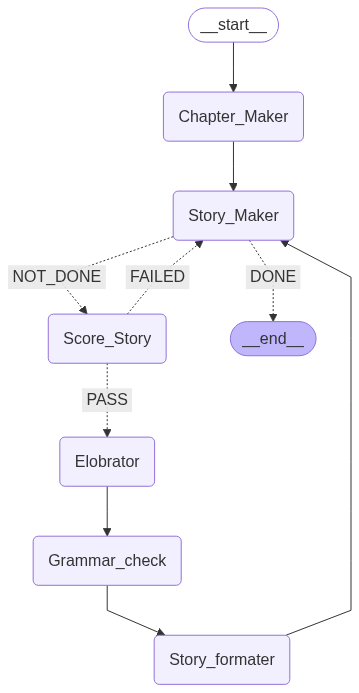

In [75]:
graph

In [46]:
plot = '''
A reclusive toymaker in an old English village crafts a porcelain doll named Elspeth—but unknown to the world, he uses forbidden folk rituals and bone fragments from his deceased daughter to "bring her back." Generations later, the doll resurfaces in an antique shop, setting off a terrifying chain of events in a modern family’s life.

The story slowly shifts from mystery to psychological horror, with increasingly surreal and disturbing manifestations tied to the doll’s presence—culminating in an ancient curse that can only be broken by a horrifying act.

Unique Elements:
-> The doll records voices—but only whispers never spoken aloud.

-> The doll moves, but only when no one is watching—and rewrites old family photographs.

-> Cursed dreams become real injuries.

-> The doll begins to replace the youngest child emotionally and physically.

-> Ancient rites tied to Celtic mythology woven into the climax.
'''
max_chapters = 4

In [47]:
graph.invoke({'plot':plot,'max_chapters':max_chapters},{"recursion_limit": 100})

Chapter Maker Started
{'Story_Name': 'The Hollow Queen', 'Chapters': {'1': 'The Whispering Cradle', '2': 'Eyes in the Glass Darkly', '3': 'Beneath the Porcelain Skin', '4': 'The Curse of the Hollow Queen'}}
Chapter Maker Ended
Story Maker Started


/var/folders/8l/zl99_gy92mg5qxxvz9x0knw00000gn/T/ipykernel_4744/2139553866.py:30: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  story_response = story_chain({


Story Maker Ended
Score Story Started
Chapter 0 passeed with score 98
Score Story Ended
current chapter score 98
Elaborate Story Started
Elaborate Story Ended
Story Maker Started
Story Maker Ended
Score Story Started
Chapter 1 passeed with score 98
Score Story Ended
current chapter score 98
Elaborate Story Started
Elaborate Story Ended
Story Maker Started
Story Maker Ended
Score Story Started
Chapter 2 passeed with score 98
Score Story Ended
current chapter score 98
Elaborate Story Started
Elaborate Story Ended
Story Maker Started
Story Maker Ended
Score Story Started
Chapter 3 passeed with score 98
Score Story Ended
current chapter score 98
Elaborate Story Started
Elaborate Story Ended
Story Maker Started


{'plot': '\nA reclusive toymaker in an old English village crafts a porcelain doll named Elspeth—but unknown to the world, he uses forbidden folk rituals and bone fragments from his deceased daughter to "bring her back." Generations later, the doll resurfaces in an antique shop, setting off a terrifying chain of events in a modern family’s life.\n\nThe story slowly shifts from mystery to psychological horror, with increasingly surreal and disturbing manifestations tied to the doll’s presence—culminating in an ancient curse that can only be broken by a horrifying act.\n\nUnique Elements:\n-> The doll records voices—but only whispers never spoken aloud.\n\n-> The doll moves, but only when no one is watching—and rewrites old family photographs.\n\n-> Cursed dreams become real injuries.\n\n-> The doll begins to replace the youngest child emotionally and physically.\n\n-> Ancient rites tied to Celtic mythology woven into the climax.\n',
 'max_chapters': 4,
 'story_name': 'The Hollow Queen',